In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!chmod 755 -R /content/drive/MyDrive/virtual_env/bin

In [ ]:
!source /content/drive/MyDrive/virtual_env/bin/activate; pip install --quiet scvi-colab


In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
from scvi_colab import install
install()

In [ ]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch
from adjustText import adjust_text
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from glob import iglob
from scipy import sparse
from scipy.sparse import coo_matrix
import math
from scib_metrics.benchmark import Benchmarker

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

In [ ]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
output_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/inh"

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"
model_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/inh/scvi_model"
integ_dir="/content/drive/MyDrive/LeoDai/Private_Data/Integration/"

In [ ]:
adata_human = sc.read_h5ad(os.path.join(integ_dir,"human_common_genes.h5ad"))
adata_human.obs['sample'] = adata_human.obs['donor']
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/human"

human_mask = sc.read_h5ad(os.path.join(input_dir,"human_inh_raw_filt_norm_subclass_scANVI.h5ad"))
adata_human = adata_human[human_mask.obs_names,:]
adata_human.obs['subclass'] = human_mask.obs['subclass']

In [ ]:
input_chimp_dir = "/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/chimp"
adata_chimp = sc.read_h5ad(os.path.join(integ_dir,"chimp_common_genes.h5ad"))
input_dir="/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/rat"
rat_mask = sc.read_h5ad(os.path.join(input_dir,"full_adata.h5ad"))
rat_mask
input_rat_dir = "/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/rat"
adata_rat = sc.read_h5ad(os.path.join(integ_dir,"rat_common_genes.h5ad"))

In [ ]:
rat_mask = rat_mask[rat_mask.obs['class']=="GABAergic",:]
adata_rat = adata_rat[rat_mask.obs_names,:]
adata_rat.obs['subclass'] = rat_mask.obs['subclass']

In [ ]:
input_dir = "/content/drive/MyDrive/LeoDai/Private_Data/Clustering/Chimp"
chimp_mask = sc.read_h5ad(os.path.join(input_dir,"Chimp_inh_level2_level3_cluster.h5ad"))
adata_chimp = adata_chimp[adata_chimp.obs_names.isin(chimp_mask.obs_names),:]

chimp_mask = chimp_mask[chimp_mask.obs_names.isin(adata_chimp.obs_names),:]
chimp_mask

In [ ]:
adata_chimp.obs['subclass'] = chimp_mask.obs['subclass']
adata_rat.obs['subclass'] = rat_mask.obs['subclass']
adata_rat
full_adata = ad.concat([adata_rat,adata_chimp,adata_human],axis=0, join="inner",merge='same')
full_adata

In [ ]:
full_adata.obs.subclass.replace("SST CHODL","Sst Chodl",inplace=True)
full_adata.obs.subclass.replace("MEIS2","Meis2",inplace=True)
full_adata.obs.subclass.replace("Noval","Novel",inplace=True)
full_adata.obs.subclass.replace("SNCG","Sncg",inplace=True)
full_adata.obs.subclass.replace("LAMP5","Lamp5",inplace=True)
full_adata.obs.subclass.replace("PVALB","Pvalb",inplace=True)
full_adata.obs.subclass.replace("SST","Sst",inplace=True)
full_adata.obs.subclass.replace("VIP","Vip",inplace=True)
full_adata.obs.subclass.replace("Sst_Chodl","Sst Chodl",inplace=True)
full_adata.obs['subclass_rename'] = full_adata.obs['subclass']

In [ ]:
#####
#save raw count =
#normalization
#log transform
full_adata.raw = full_adata

sc.pp.normalize_total(full_adata, target_sum=1e4)
sc.pp.log1p(full_adata)
full_adata.layers["counts"] = full_adata.X.copy()  # preserve counts
  # freeze the state in `.raw`
#highly variable genes top 1500
sc.pp.highly_variable_genes(
    full_adata,
    n_top_genes=1500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample",
)
#Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various
#matrices inside the anndata. It’s important to run this function with the correct arguments
#so scvi-tools is notified that your dataset has batches, annotations, etc.
scvi.model.SCVI.setup_anndata(
    full_adata,
    layer="counts",
    categorical_covariate_keys=["sample","species"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"],
)
#create and train the scvi model
#negative binomial
n_latent =30
model = scvi.model.SCVI(full_adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
model.save(os.path.join(model_dir,"inh_full_adata_scvi_model" + str(n_latent)), overwrite=True)

In [ ]:
n_latent =30
model = scvi.model.SCVI.load(os.path.join(model_dir,"inh_full_adata_scvi_model" + str(n_latent)), adata=full_adata)

In [ ]:
#save scvi output to adata
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
full_adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape
# use scVI latent space for UMAP generation
sc.pp.neighbors(full_adata, use_rep=SCVI_LATENT_KEY)

SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(full_adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(full_adata, min_dist=0.5)

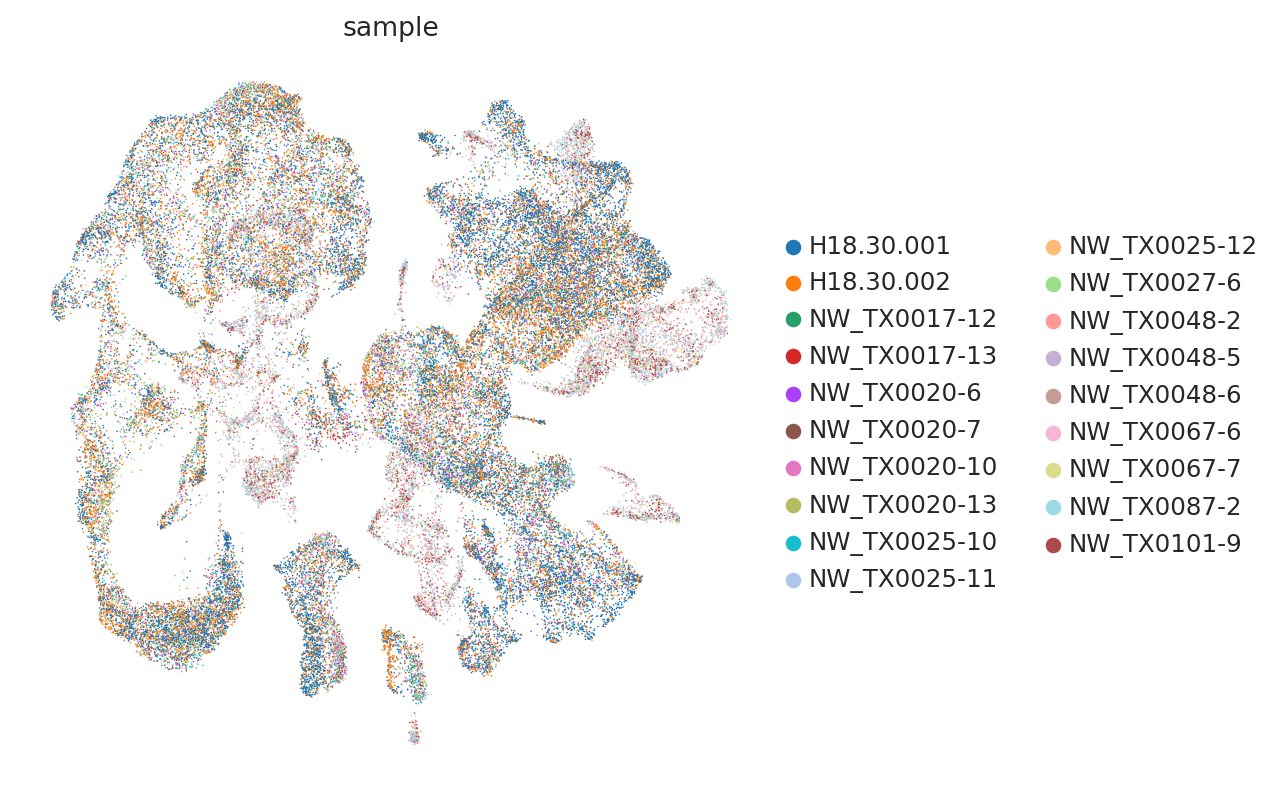

In [ ]:
sc.pl.umap(
    full_adata,
    color=["sample"],
    frameon=False,
    cmap="tab20",
    show=False,
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_sample_mixture_leiden.png"),bbox_inches='tight')

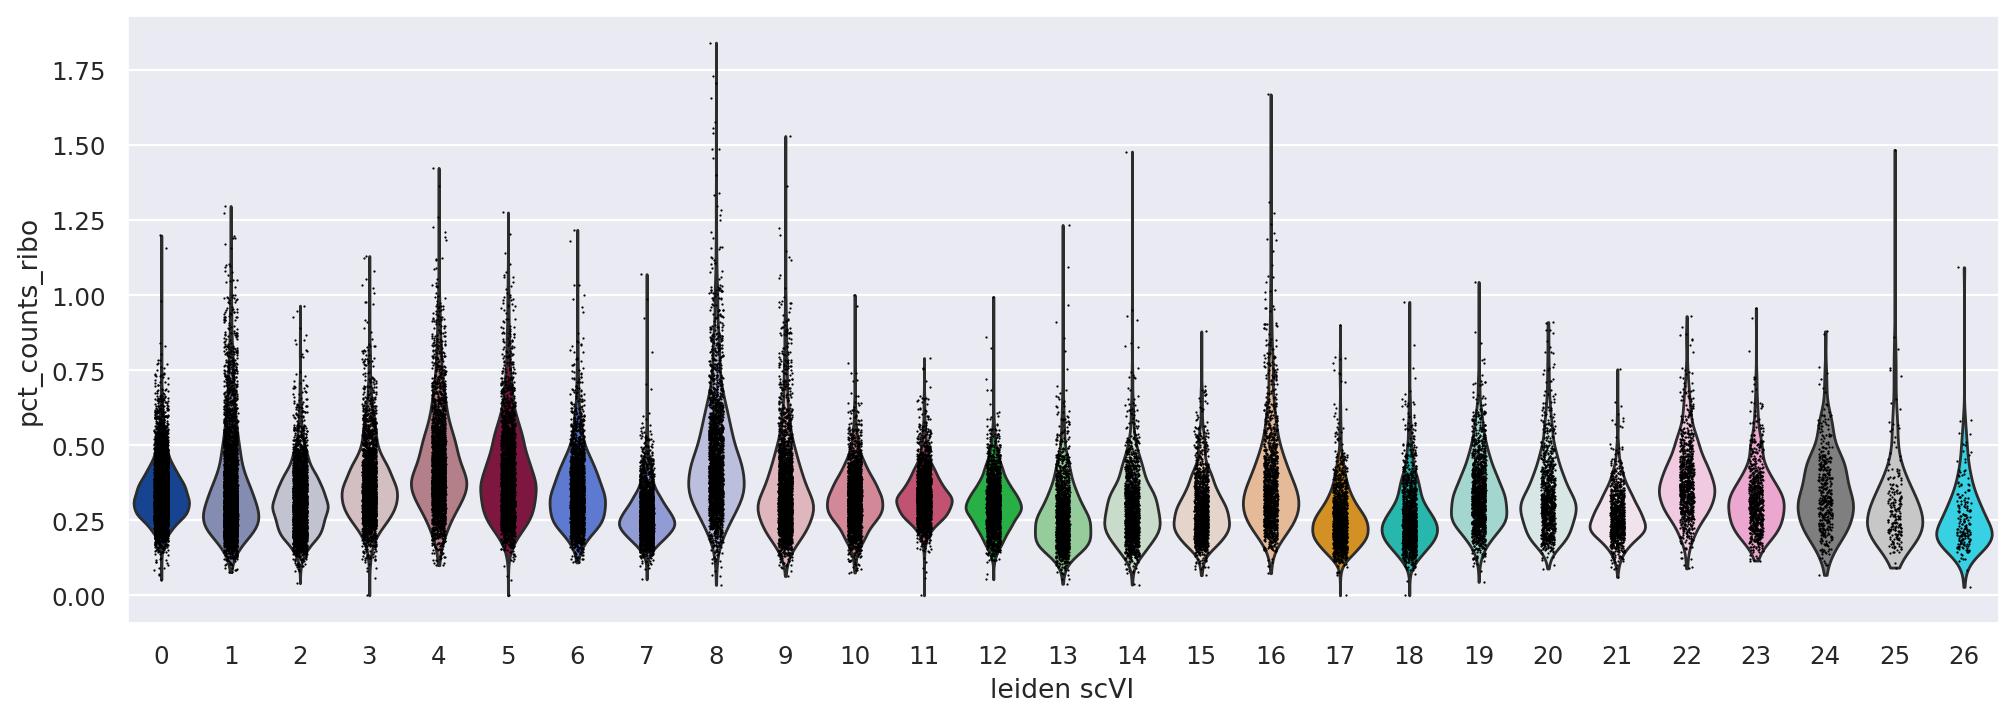

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "pct_counts_ribo", groupby="leiden_scVI", ax=axs)
#sc.pl.violin(full_adata, "leiden", groupby="DE_subclass", ax=axs[1])

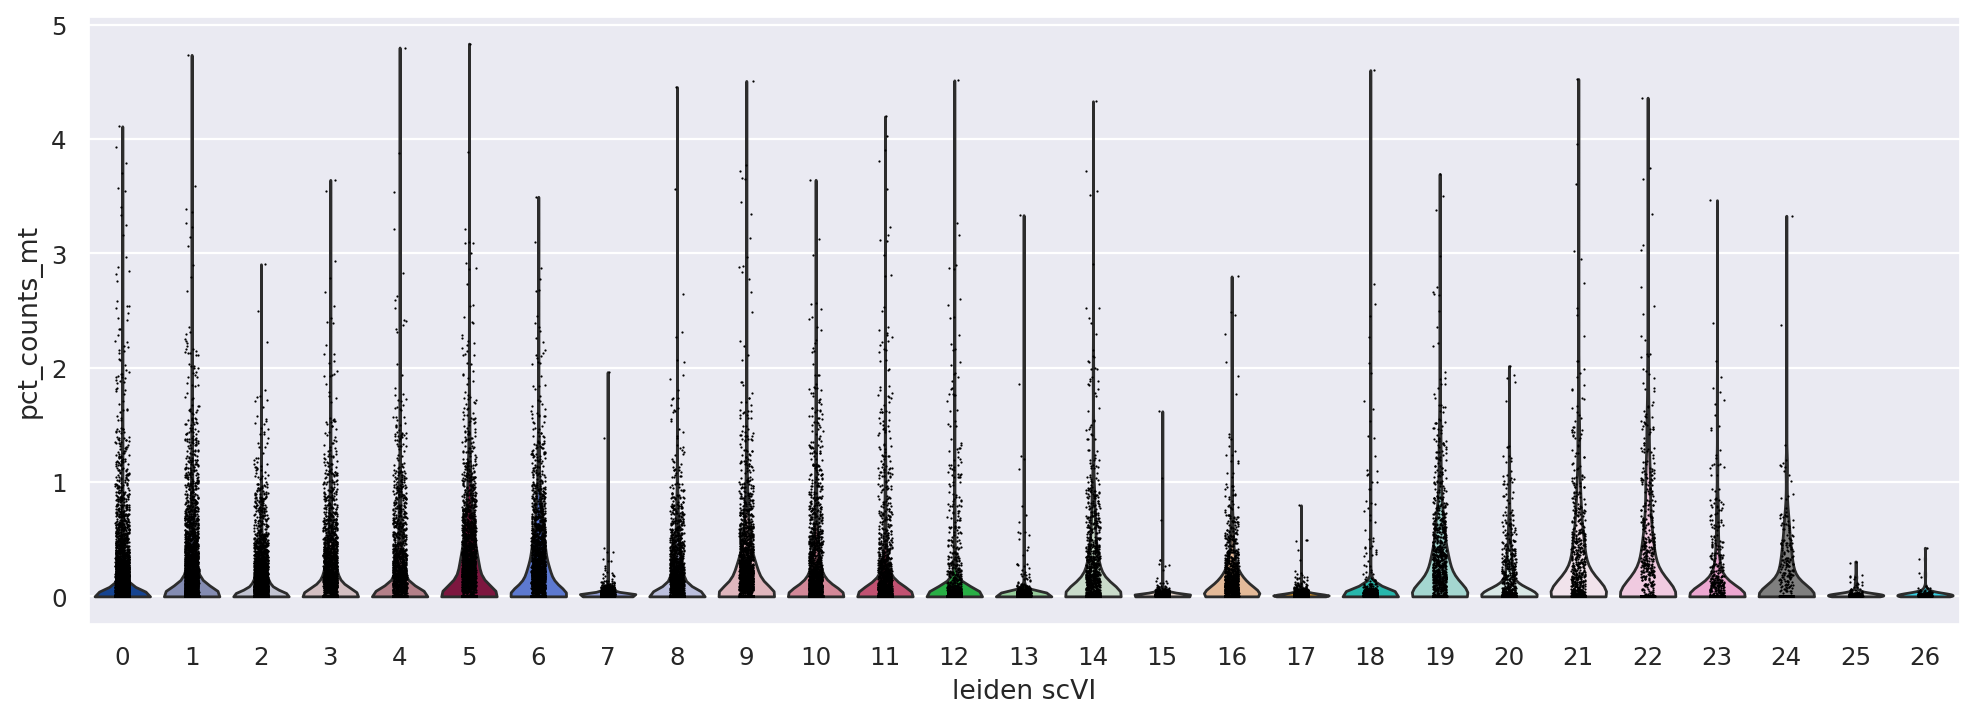

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "pct_counts_ribo", groupby="leiden_scVI", ax=axs)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "pct_counts_mt", groupby="leiden_scVI", ax=axs)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "n_genes", groupby="leiden_scVI", ax=axs)

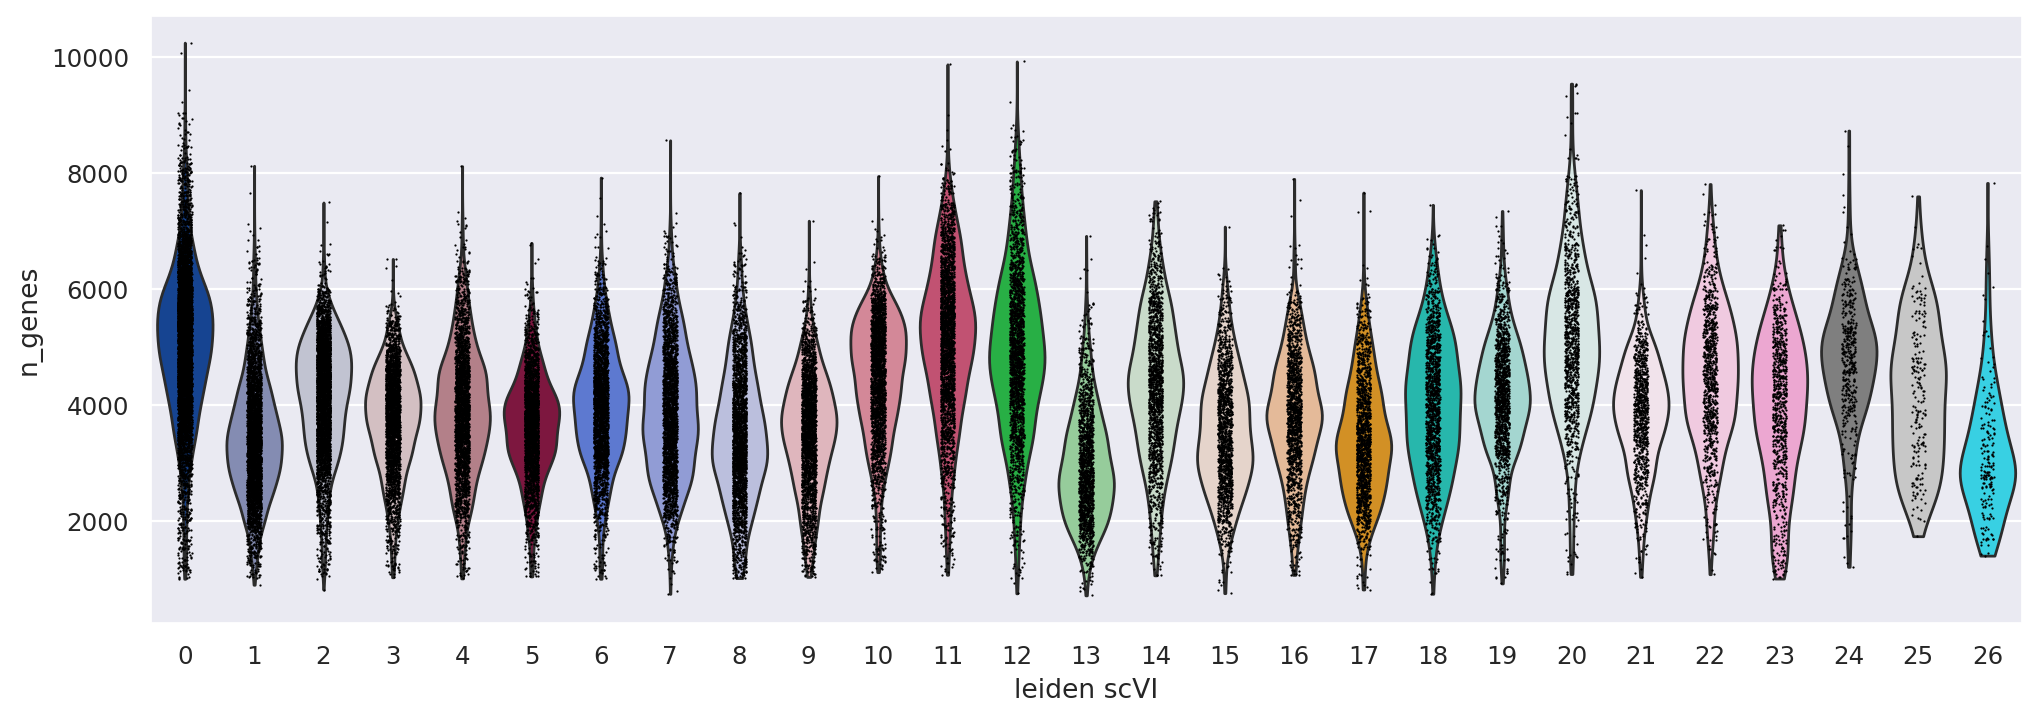

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
sc.pl.violin(full_adata, "n_genes", groupby="leiden_scVI", ax=axs)

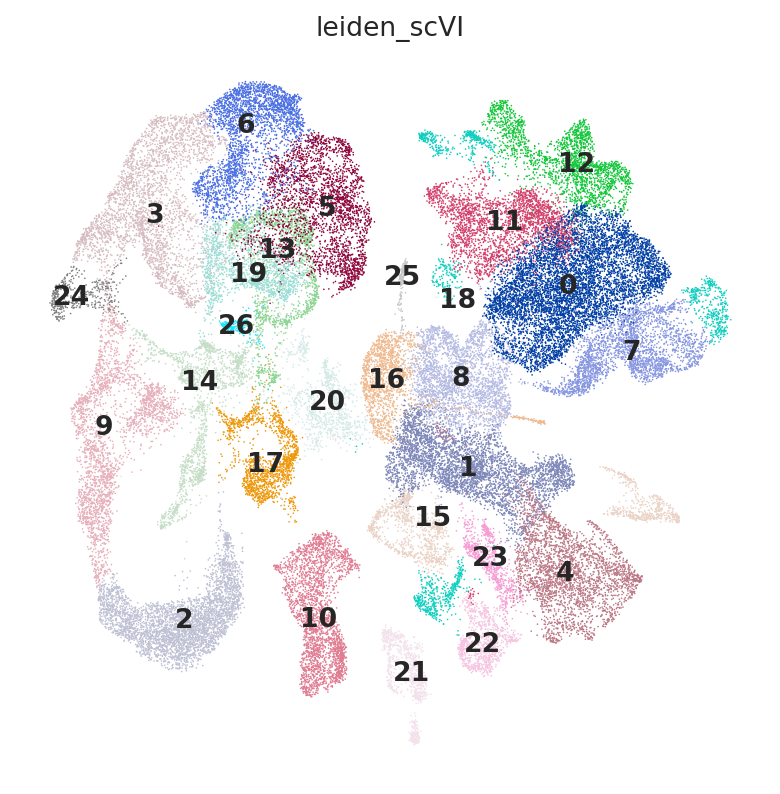

In [ ]:

sc.pl.umap(
    full_adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_leiden_number.png"),bbox_inches='tight')

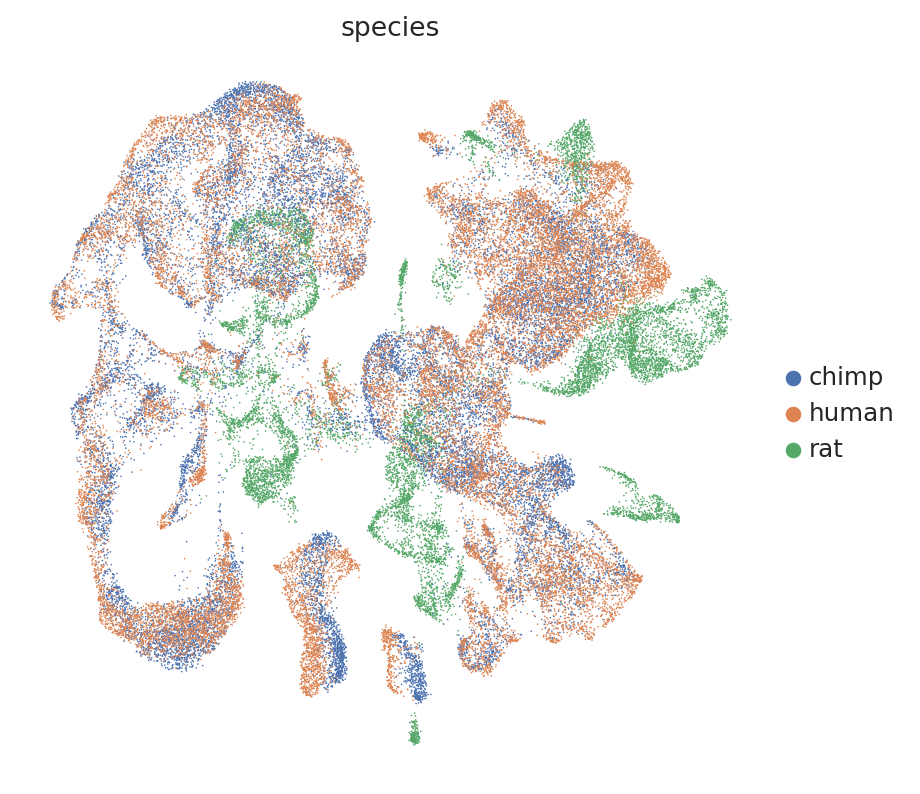

In [ ]:
sc.pl.umap(
    full_adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_leiden_number.png"),bbox_inches='tight')
sc.pl.umap(
    full_adata,
    color=["species"],
    frameon=False,
    cmap="tab20",
    #legend_loc = "on data",
    show=False,
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scvi_leiden_species.png"),bbox_inches='tight')
sc.pl.umap(
    full_adata,
    color=["subclass"],
    frameon=False,
    cmap="tab20",
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    show=False,
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scvi_leiden_subclass.png"),bbox_inches='tight')

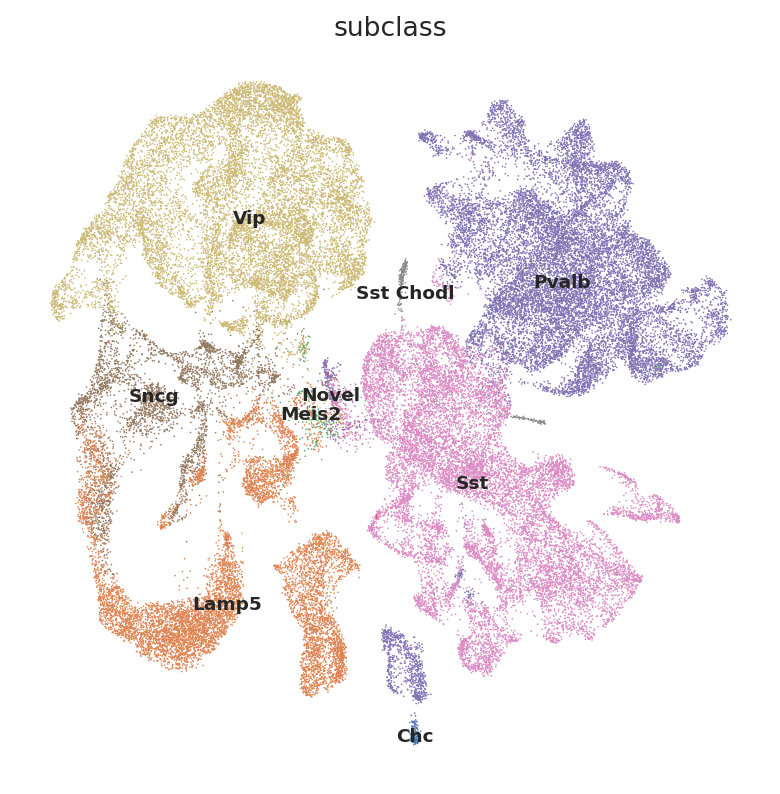

In [ ]:
sc.pl.umap(
    full_adata,
    color=["subclass"],
    frameon=False,
    cmap="tab20",
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    show=False,
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scvi_leiden_subclass.png"),bbox_inches='tight')

In [ ]:
bm = Benchmarker(
    full_adata,
    batch_key="sample",
    label_key="subclass",
    embedding_obsm_keys=[SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=full_adata,
    labels_key="subclass",
    unlabeled_category="Unknown",
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)
SCANVI_LATENT_KEY = "X_scANVI"
full_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(full_adata)
scanvi_model.save(os.path.join(model_dir,"full_adata_scANvi_model" + str(n_latent)), overwrite=True)

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
scanvi_model = scvi.model.SCANVI.load(os.path.join(model_dir,"full_adata_scANvi_model" + str(n_latent)), adata=full_adata)

In [ ]:
sc.pp.neighbors(full_adata, use_rep=SCANVI_LATENT_KEY)
SCANVI_CLUSTERS_KEY = "leiden_scANVI"
sc.tl.leiden(full_adata, key_added=SCANVI_CLUSTERS_KEY, resolution=0.5)
sc.tl.umap(full_adata, min_dist=0.4)

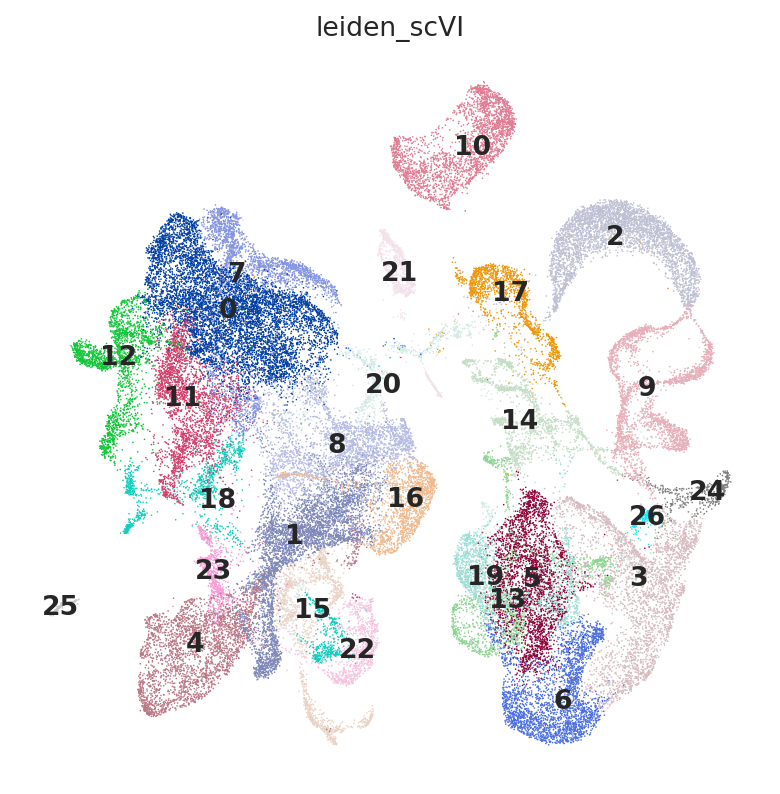

In [ ]:
sc.pl.umap(
    full_adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scANVI_leiden_number.png"),bbox_inches='tight')

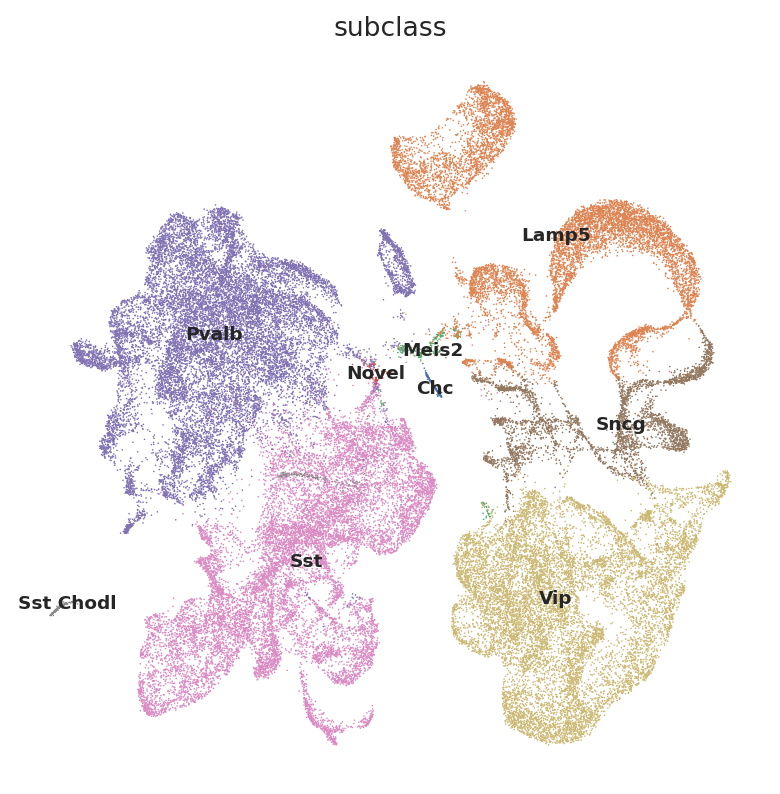

In [ ]:
sc.pl.umap(
    full_adata,
    color=['subclass'],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scanvi_subclass.png"),bbox_inches='tight')
sc.pl.umap(
    full_adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scANVI_leiden_number.png"),bbox_inches='tight')


In [ ]:
bm = Benchmarker(
    full_adata,
    batch_key="sample",
    label_key="subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:  60%|██████    | 6/10 [00:08<00:05,  1.31s/it, Batch correction: kbet_per_label]/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.10/dist-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is d

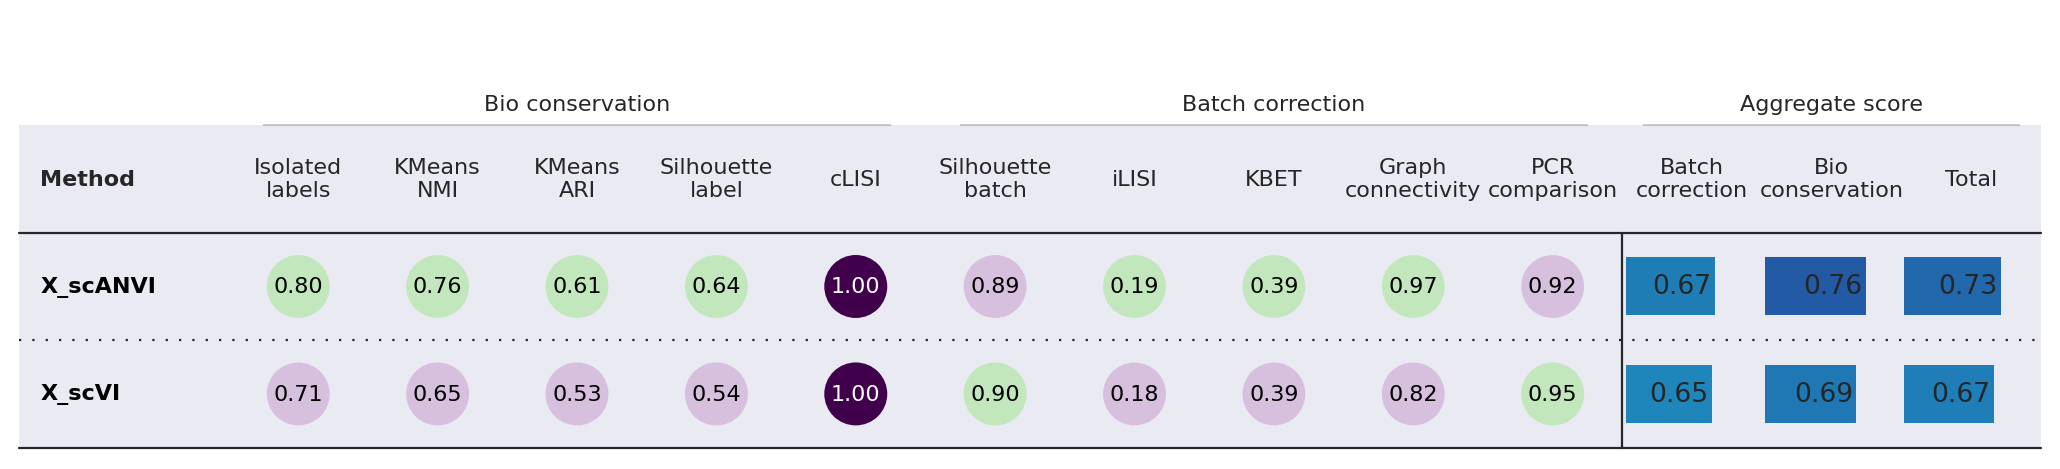

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
bm = Benchmarker(
    full_adata,
    batch_key="sample",
    label_key="subclass",
    embedding_obsm_keys=[SCANVI_LATENT_KEY, SCVI_LATENT_KEY],
    n_jobs=6,
)
bm.benchmark()

bm.plot_results_table(min_max_scale=False)

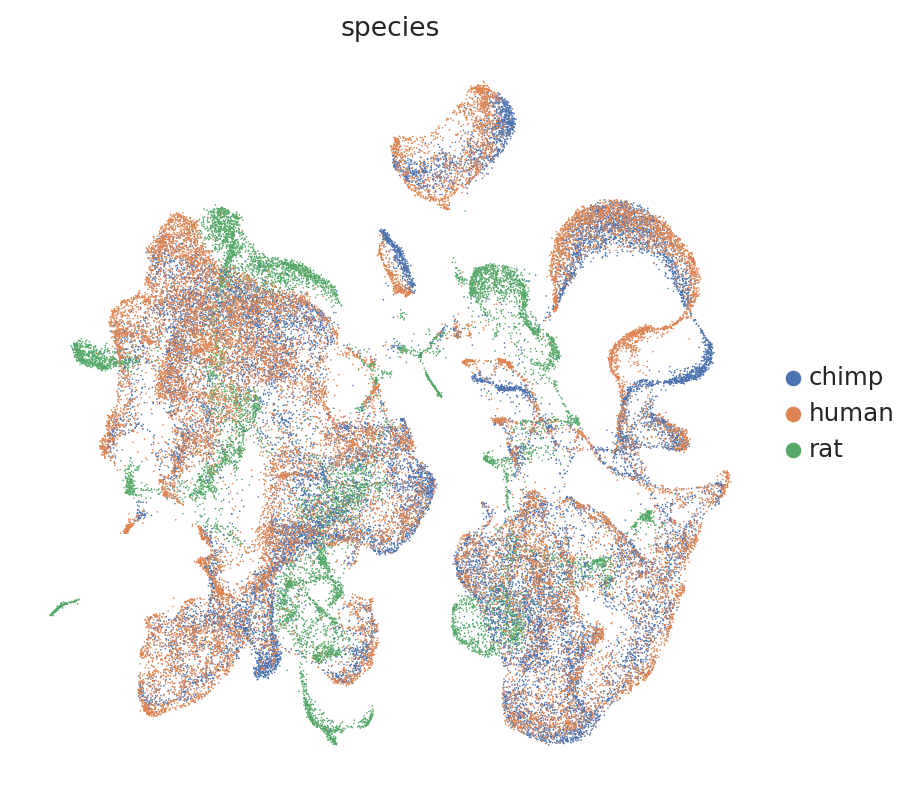

In [ ]:
sc.pl.umap(
    full_adata,
    color=["species"],
    frameon=False,
    cmap="tab20",
    #legend_loc = "on data",
    show=False,
    wspace=0.5
)
plt.savefig(os.path.join(output_dir,"inh_scANVI_leiden_species.png"),bbox_inches='tight')

[<Axes: title={'center': 'subclass'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'species'}, xlabel='UMAP1', ylabel='UMAP2'>]

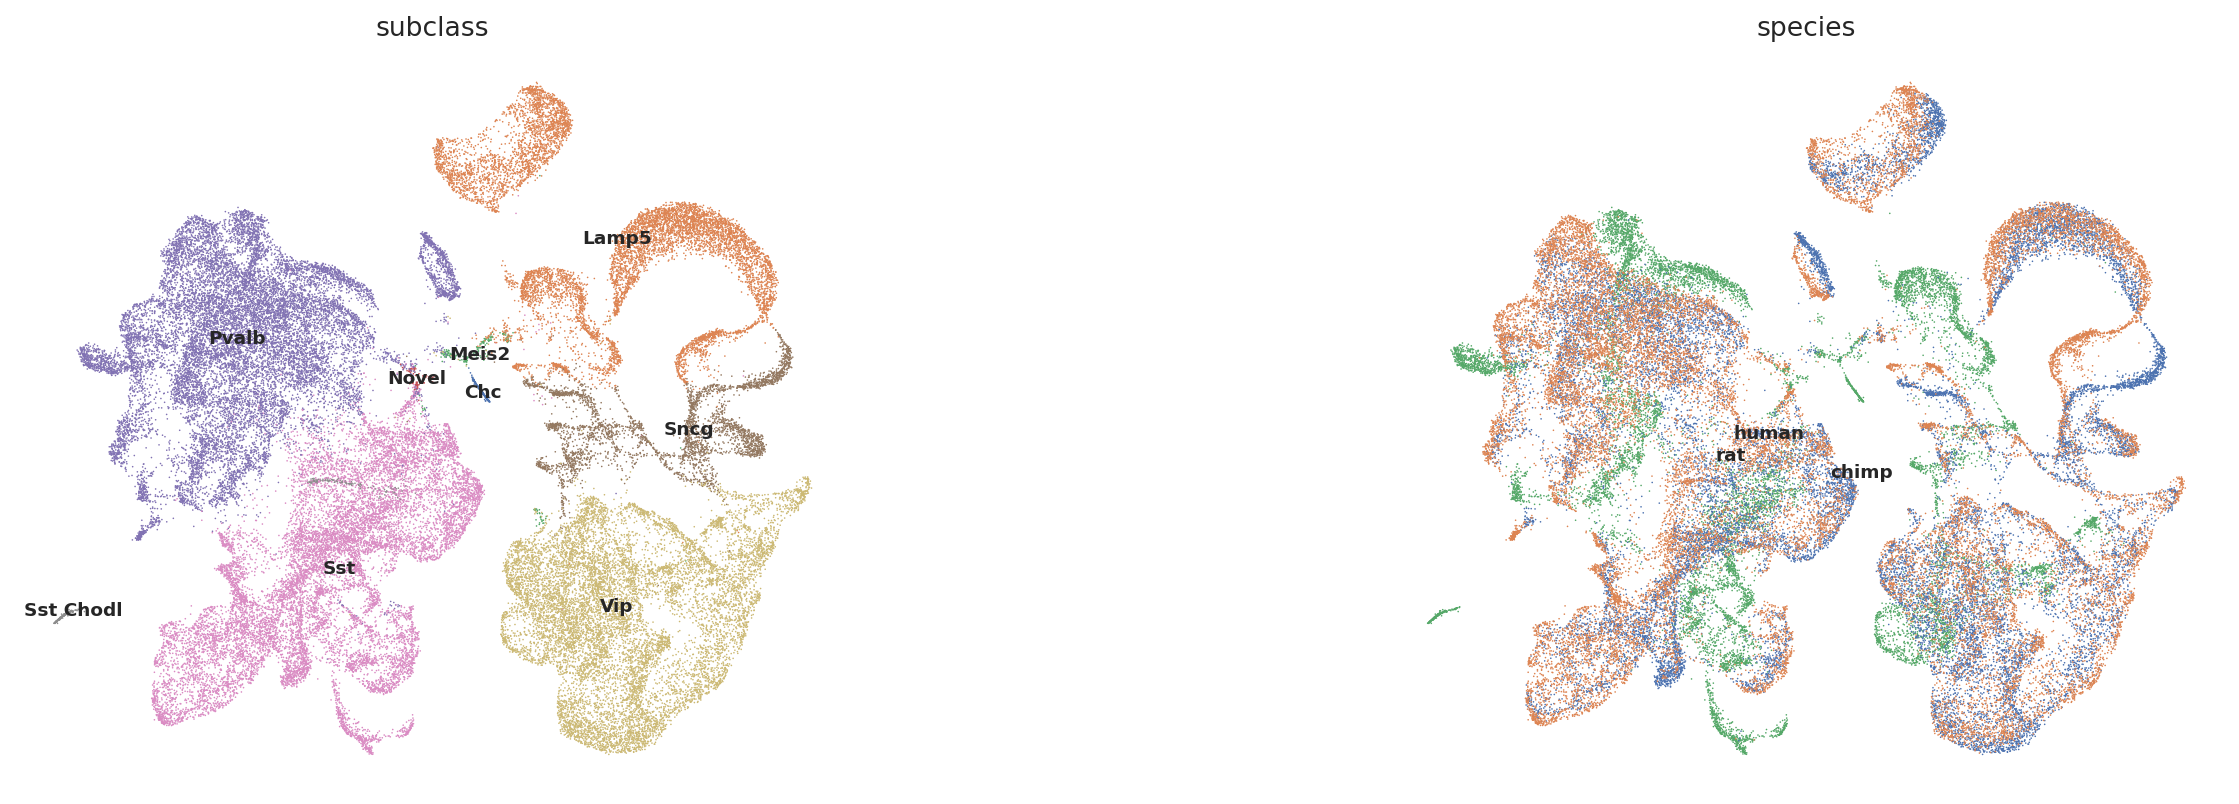

In [ ]:
sc.pl.umap(
    full_adata,
    color=['subclass',"species"],
    frameon=False,
    cmap="tab20",
    show=False,
    legend_loc = "on data",
    legend_fontsize = 'x-small',
    wspace=0.5
)
#plt.savefig(os.path.join(output_dir,"inh_scanvi_subclass.png"),bbox_inches='tight')

In [ ]:
from adjustText import adjust_text

def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [ ]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 200, "figure.frameon": False}):
    ax = sc.pl.umap(full_adata, color="subclass", show=False, legend_loc=None, frameon=False)
    gen_mpl_labels(
        full_adata,
        "subclass",
        exclude=("None",),  # This was before we had the `nan` behaviour
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=7,fontweight='bold'),
    )
    fig = ax.get_figure()
    fig.tight_layout()
    #plt.show()
    fig.savefig(os.path.join(output_dir,"inh_three_species_scANVI_subclass_v2.png"))

In [ ]:
full_adata.write_h5ad("/content/drive/MyDrive/LeoDai/Private_Data/Integration/scANVI/inh/inh_full_adata_scANvi_subclass.h5ad",compression="gzip")